<a href="https://colab.research.google.com/github/ryannhongg/geneCorrelation.R/blob/main/OSD_513_parameterized_performing_dgea_capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div>
<img src="https://www.nasa.gov/wp-content/uploads/2024/07/osdr-gl4hs-logo.png" width="600"/>
</div>

# **NOTEBOOK 6: Performing differential gene expression analysis**
In this notebook, you will run statistical tests to determine which genes are differentially expressed between ground control and space flight groups.

## **Objectives of this notebook**
The primary objective of this notebook is to perform [differential gene expression analysis](https://www.youtube.com/watch?v=tlf6wYJrwKY) (DGEA) using [Python's implementation of DESeq2](https://pydeseq2.readthedocs.io/en/stable/auto_examples/plot_step_by_step.html#sphx-glr-auto-examples-plot-step-by-step-py) to find genes which have a large enough [log2 fold change](https://www.biostars.org/p/9505003/) between ground control and space flight as well as a low enough adjusted [p-value](https://www.youtube.com/watch?v=vemZtEM63GY) as to be statistically significant.

DGEA is actually a series of several [statistical hypothesis tests](https://www.youtube.com/watch?v=0oc49DyA3hU) - one per gene - that compares the expression of that gene between 2 groups (e.g. spaceflight vs ground control). The null hypothesis is that there is no significant difference in the expression of that gene between the 2 groups. The alternate hypothesis is that there is a significant difference between the expression of that gene between those 2 groups. This difference can either be over-regulated gene expression or under-regulated gene expression, making this a [two-tailed test](https://www.youtube.com/watch?v=bsZGt-caXO4).

Additionally, you will use principal components analysis (PCA) to visualize the gene expression of all the samples in your dataset to determine if the samples separate according to their condition (e.g. space flight and ground control). You can learn more about PCA [here](https://youtu.be/HMOI_lkzW08?si=zTSi-OclCvmEvdVR). After performing DGEA, you will create a volcano plot of the p-values to visualize their distribution. You can learn more about volcano plots [here](https://www.youtube.com/watch?v=7aWAdw2jhj0).

We will no longer use the FASTQ data from the previous notebooks regarding the single sample paired end reads. Instead, we will download the GeneLab-processed count data for all the samples in your dataset and use that as our starting point for this and the next notebook.

## **UNIX commands introduced in this notebook**

[`unzip`](https://linux.die.net/man/1/unzip) command to extract the files in a ZIP archive.

# Prepare runtime environment for lab

In [ ]:
# mount google drive to mnt mount point
from google.colab import drive
drive.flush_and_unmount()
drive.mount("mnt")


Drive not mounted, so nothing to flush and unmount.
Mounted at mnt


In [ ]:
# time the notebook
import datetime
start_time = datetime.datetime.now()
print('notebook start time: ', start_time.strftime('%Y-%m-%d %H:%M:%S'))

notebook start time:  2025-08-15 03:24:40


In [ ]:
# define OSD dataset number to use for this notebook

OSD_DATASET='513'
GLDS_DATASET='513'

#OSD_DATASET='678'
#GLDS_DATASET='612'

#OSD_DATASET='104'
#GLDS_DATASET='104'

#OSD_DATASET='254'
#GLDS_DATASET='254'

#OSD_DATASET='580'
#GLDS_DATASET='573'

#OSD_DATASET='137'
#GLDS_DATASET='137'

#OSD_DATASET='47'
#GLDS_DATASET='47'

#OSD_DATASET='48'
#GLDS_DATASET='48'

#OSD_DATASET='120'
#GLDS_DATASET='120'

#OSD_DATASET='245'
#GLDS_DATASET='245'



In [ ]:
# define factors for experiment
# NOTE: the configs listed below are examples that work with specific OSD datasets
# these configs will not necessarily work with the OSD dataset that you've chosen
# We defined 5 different configs, but on the bottom of this cell, we only choose
# one of them and store in a variable called "config". You can run one config for
# the notebook at a time, and the results for each config will be stored separately.
# The results of this experiment will be stored in your google drive under
# NASA/GL4HS/CAPSTONE/<experiment name>

# young GC vs old GC
config_1 = {
    'experiment name': 'young_GC_vs_old_GC',
    'factor_list': ['Factor Value[Spaceflight]', 'Factor Value[Age]'],
    'group_A': {'Factor Value[Spaceflight]': 'Ground Control', 'Factor Value[Age]': '10 to 12'},
    'group_B': {'Factor Value[Spaceflight]': 'Ground Control', 'Factor Value[Age]': '32'}
}

# young FLT vs old FLT
config_2 = {
    'experiment name': 'young_FLT_vs_old_FLT',
    'factor_list': ['Factor Value[Spaceflight]', 'Factor Value[Age]'],
    'group_A': {'Factor Value[Spaceflight]': 'Space Flight', 'Factor Value[Age]': '10 to 12'},
    'group_B': {'Factor Value[Spaceflight]': 'Space Flight', 'Factor Value[Age]': '32'}
}

# young GC vs young FLT
config_3 = {
    'experiment name': 'young_GC_vs_young_FLT',
    'factor_list': ['Factor Value[Spaceflight]', 'Factor Value[Age]'],
    'group_A': {'Factor Value[Spaceflight]': 'Ground Control', 'Factor Value[Age]': '10 to 12'},
    'group_B': {'Factor Value[Spaceflight]': 'Space Flight', 'Factor Value[Age]': '10 to 12'}
}

# old GC vs old FLT
config_4 = {
    'experiment name': 'old_GC_vs_old_FLT',
    'factor_list': ['Factor Value[Spaceflight]', 'Factor Value[Age]'],
    'group_A': {'Factor Value[Spaceflight]': 'Ground Control', 'Factor Value[Age]': '32'},
    'group_B': {'Factor Value[Spaceflight]': 'Space Flight', 'Factor Value[Age]': '32'}
}

# FLT vs GC
config_5 = {
    'experiment name': 'FLT_vs_GC',
    'factor_list': ['Factor Value[Spaceflight]'],
    'group_A': {'Factor Value[Spaceflight]': 'Space Flight'},
    'group_B': {'Factor Value[Spaceflight]': 'Ground Control'}
}

# YNG vs OLD
config_6 = {
    'experiment name': 'YNG_vs_OLD',
    'factor_list': ['Factor Value[Age]'],
    'group_A': {'Factor Value[Age]': '10 to 12'},
    'group_B': {'Factor Value[Age]': '32'}
}

# LONG vs SHORT
config_7 = {
    'experiment name': 'LONG_vs_SHORT',
    'factor_list': ['Factor Value[Duration]'],
    'group_A': {'Factor Value[Duration]': '~25'},
    'group_B': {'Factor Value[Duration]': '~75'}
}
config = config_5


In [ ]:
# define the threshold for coefficient of variation
CV_THRESH=0.5

In [ ]:
# define log2 fold change threshold
LOG2FC_THRESH = 1.5

In [ ]:
# define alpha level of significance
ALPHA_LEVEL = 0.05

In [ ]:
# create output directory
import os
OUTPUT_DIR="/content/mnt/MyDrive/NASA/GL4HS/CAPSTONE/" + OSD_DATASET + '/' + config['experiment name']
if not os.path.exists(OUTPUT_DIR):
  !mkdir -p {META_DIR}

In [ ]:
# create META_DIR directory for metadata
import os
META_DIR=OUTPUT_DIR + "/META/"
if os.path.exists(META_DIR):
  !rm -rf {META_DIR}
!mkdir -p {META_DIR}

In [ ]:
# create DGEA_DIR directory for DGEA output
DGEA_DIR=OUTPUT_DIR + "/DGEA/"
if os.path.exists(DGEA_DIR):
  !rm -rf {DGEA_DIR}

!mkdir -p {DGEA_DIR}

In [ ]:
# install packages and import the modules needed to do DGEA
!pip install pyDeseq2 > /dev/null
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
import numpy as np
!pip install scikit-learn > /dev/null
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
!pip install Ensembl_converter > /dev/null
from Ensembl_converter import EnsemblConverter
!pip install mygene > /dev/null
import mygene

# Define Python methods for notebook

In [ ]:
# define method for removing NaNs from dataframe
def drop_nans(df):
  # drop NaN rows
  df = df.dropna(inplace=False)
  return df

You can learn more about Python NaN [here](https://stackoverflow.com/questions/17628613/what-is-inf-and-nan).

In [ ]:
# define method for dropping low-count genes
def drop_lowcount(df, threshold=10):

  # let's drop any low-count genes
  if 'transcript' in df.columns:
    df = df[df.drop(columns=['transcript']).sum(axis=1) >= threshold]
  elif 'Unnamed: 0' in df.columns:
    df = df[df.drop(columns=['Unnamed: 0']).sum(axis=1) >= threshold]
  else:
    raise Exception("check file format")
  return df


You can read more about low-count gene thresholds [here](https://www.biostars.org/p/251922/).

In [ ]:
# define method for filtering low coefficient-of-variation genes
def filter_cvs(df, thresh):
  import numpy as np
  import matplotlib.pyplot as plt

  # calculate coefficient of variation
  cvs=list()
  for i in range(len(df)):
    m = np.mean(df.iloc[i][1:])
    sd = np.std(df.iloc[i][1:])
    cvs.append(sd/m)

  # plot hist of dist of coev of variation
  fig, axs = plt.subplots()
  axs.hist(cvs, bins=20)

  # add labels for x and y axes
  plt.xlabel('coefficient of variation')
  plt.ylabel('number of genes')

  # keep genes with cv > thresh
  indices = list()
  for i in range(len(cvs)):
    if cvs[i] > thresh:
      indices.append(i)
  return df.iloc[indices]


You can read more about the coefficient of variation [here](https://en.wikipedia.org/wiki/Coefficient_of_variation).

In [ ]:
# define method to transpose a dataframe
def transpose_df(df, cur_index_col, new_index_col):
  df = df.set_index(cur_index_col).T
  df.reset_index(level=0, inplace=True)
  cols = [new_index_col] + list(df.columns)[1:]
  df.columns = cols
  return df

You can read more about transposition [here](https://www.geeksforgeeks.org/python-pandas-dataframe-transpose/).

In [ ]:
# define method for dropping ERCC genes from dataframe
def drop_ercc(df):
  df = df[df['Unnamed: 0'].str.contains('ERCC-') == False]
  return df

You can read more about ERCC [here](https://www.nist.gov/programs-projects/external-rna-controls-consortium).

In [ ]:
# define method for running PCA
def run_pca(_expr, _meta, samples_0, samples_1, factor_list):

  X = np.array(_expr.drop(columns=['sample']))
  y = np.array(list(factor_list))
  target_names=np.array(['group 0', 'group 1'])

  # run PCA to reduce dimensions
  pca = PCA(n_components=2)
  X_r = pca.fit_transform(X)

  # Percentage of variance explained for each components
  print(
      "explained variance ratio (first two components): %s"
      % str(pca.explained_variance_ratio_)
  )

  # plot the pca plot
  plt.figure()
  colors = ["blue", "red"]
  lw = 2
  for color, i, target_name in zip(colors, ['0', '1'], target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=0.8, lw=lw, label=target_name)
  plt.legend(loc="best", shadow=False, scatterpoints=1)
  plt.xlabel("PC1")
  plt.ylabel("PC2")
  plt.title("PCA of OSD dataset")

  # show the last digits of the sample name if the number of samples is less than 40
  if len(_expr) < 100:
    samples = list(_expr['sample'])
    for i, txt in enumerate(samples):
        plt.annotate(txt[-8:], (X_r[i][0], X_r[i][1]))

  return plt

In [ ]:
# define method to convert ensembl gene id's to gene symbols
def old_get_symbol_from_id(gene_id_list):
  # Create an instance of EnsemblConverter
  converter = EnsemblConverter()

  # Convert Ensembl IDs to gene symbols
  result = converter.convert_ids(gene_id_list)

  # Print the resulting DataFrame
  gene_symbol_list = list()
  for i in range(len(result)):
    gene_symbol_list.append(result.iloc[i]['Symbol'])

  return gene_symbol_list

In [ ]:
# define method to convert gene ids to symbols
def get_symbol_from_id(gene_list):
  import mygene

  symbol_list = list()
  mg = mygene.MyGeneInfo()
  ginfo = mg.querymany(gene_list, scopes='ensembl.gene')
  seen_genes = list()
  for g in ginfo:
    if g['query'] in seen_genes:
      continue
    if not 'symbol' in g:
      symbol_list.append(g['query'])
    else:
      symbol_list.append(g['symbol'])
    seen_genes.append(g['query'])
  return symbol_list

# Download data from OSDR

In [ ]:
# open the URL printed below in another browser window
osd_url = !echo https://visualization.osdr.nasa.gov/biodata/api/v2/dataset/OSD-{513}/files/\?format=browser
print(osd_url[0])

https://visualization.osdr.nasa.gov/biodata/api/v2/dataset/OSD-513/files/?format=browser


In [ ]:
# download OSD unnormalized count data
# NOTE: if you get an error (HTTP 404) in this cell, then open the link at the top of this section,
# find and copy the exact URL for the expression ZIP file for your dataset, and replace the
# url variable below with the exact URL for your dataset.
# if the link in the previous cell is broken, visit the OSDR Web page for your dataset to find the filenames
# and adjust the url below accordingly

import pandas as pd
#url = 'https://osdr.nasa.gov/geode-py/ws/studies/OSD-' + OSD_DATASET + '/download?source=datamanager&file=GLDS-' + GLDS_DATASET + '_rna_seq_Unnormalized_Counts.csv'
url = 'https://osdr.nasa.gov/geode-py/ws/studies/OSD-513/download?source=datamanager&file=GLDS-513_rna_seq_STAR_Unnormalized_Counts.csv'
#url='https://osdr.nasa.gov/geode-py/ws/studies/OSD-678/download?source=datamanager&file=GLDS-612_rna_seq_STAR_Unnormalized_Counts_GLbulkRNAseq.csv'
#url = 'https://osdr.nasa.gov/geode-py/ws/studies/OSD-511/download?source=datamanager&file=GLDS-511_rna_seq_STAR_Unnormalized_Counts.csv'
#url='https://osdr.nasa.gov/geode-py/ws/studies/OSD-254/download?source=datamanager&file=' + 'GLDS-254_rna_seq_Unnormalized_Counts.csv'

expr_df = pd.read_csv(url)
expr_df.head()

,Unnamed: 0,RR23_KDN_FLT_F1_techrep1,RR23_KDN_FLT_F1_techrep2,RR23_KDN_FLT_F2,RR23_KDN_FLT_F3,RR23_KDN_FLT_F4,RR23_KDN_FLT_F5,RR23_KDN_FLT_F6,RR23_KDN_FLT_F7,RR23_KDN_FLT_F8,...,RR23_KDN_VIV_V1_techrep1,RR23_KDN_VIV_V1_techrep2,RR23_KDN_VIV_V2,RR23_KDN_VIV_V3,RR23_KDN_VIV_V4,RR23_KDN_VIV_V5,RR23_KDN_VIV_V6,RR23_KDN_VIV_V7,RR23_KDN_VIV_V8,RR23_KDN_VIV_V9
0,ENSMUSG00000000001,4785,4864,4668,3118,4477,5457,3843,5989,4823,...,4393,4015,5784,4276,3359,4381,2970,3194,6603,5448
1,ENSMUSG00000000003,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ENSMUSG00000000028,53,68,46,27,33,51,42,33,41,...,29,26,49,43,34,42,39,34,70,55
3,ENSMUSG00000000031,3,1,0,0,1,0,1,3,2,...,2,2,1,2,0,9,2,1,9,0
4,ENSMUSG00000000037,7,8,4,5,6,7,3,8,7,...,15,7,7,6,6,7,9,5,17,6


In [ ]:
# identify the shape of the expr_df dataframe
expr_df.shape

(56840, 31)

In [ ]:
# call drop_ercc
# there may or may not be ERCC records to drop
expr_df = drop_ercc(expr_df)
expr_df.shape

(56748, 31)

In [ ]:
# call drop_nans
# there may or may not be NaNs to drop
expr_df = drop_nans(expr_df)
expr_df.shape

(56748, 31)

In [ ]:
# call drop_lowcount with threshold=50
expr_df = drop_lowcount(expr_df, threshold=50)
expr_df.shape

(23038, 31)

(6891, 31)

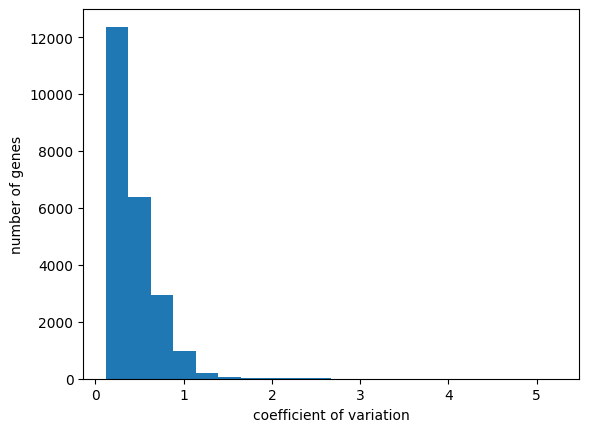

In [ ]:
# call filter_cvs with thresh=CV_THRESH
expr_df = filter_cvs(expr_df, thresh=CV_THRESH)
expr_df.shape

In [ ]:
# first save expr_df as genes x samples to file in gdrive for use in next notebook
expr_df.to_csv(DGEA_DIR + '/expr_df.csv', sep=',', index=None)

In [ ]:
# then transpose expr_df to be samples x genes
expr_df = transpose_df(expr_df, 'Unnamed: 0', 'sample')
expr_df.head()

,sample,ENSMUSG00000000031,ENSMUSG00000000037,ENSMUSG00000000120,ENSMUSG00000000142,ENSMUSG00000000197,ENSMUSG00000000204,ENSMUSG00000000223,ENSMUSG00000000318,ENSMUSG00000000359,...,ENSMUSG00002076804,ENSMUSG00002076809,ENSMUSG00002076820,ENSMUSG00002076842,ENSMUSG00002076859,ENSMUSG00002076860,ENSMUSG00002076874,ENSMUSG00002076902,ENSMUSG00002076903,ENSMUSG00002076983
0,RR23_KDN_FLT_F1_techrep1,3,7,24,66,7,7,7,75,141,...,0,561,1,2,4,1,6,3,1,3
1,RR23_KDN_FLT_F1_techrep2,1,8,22,69,13,4,3,70,153,...,1,469,1,0,4,2,10,5,2,5
2,RR23_KDN_FLT_F2,0,4,21,88,19,9,1,31,254,...,2,614,3,1,6,1,5,7,2,12
3,RR23_KDN_FLT_F3,0,5,7,20,15,7,2,15,120,...,3,457,2,0,3,2,6,4,2,2
4,RR23_KDN_FLT_F4,1,6,16,56,35,15,2,53,205,...,3,403,1,6,6,5,10,10,3,7


In [ ]:
# determine the shape of the transposed expr_df dataframe
expr_df.shape

(30, 6892)

In [ ]:
# read in  metadata

# NOTE: if you get an error (HTTP 404) in this cell, then open the link at the top of this section,
# find and copy the exact URL for the metadata ZIP file for your dataset, and replace the
# url variable below with the exact URL for your dataset.
# IMPORTANT NOTE: if you paste the URL from the OSDR Web page, then you need to insert the
# backslash ("\") character before the ampersand ("&") and the question mark ("?")
# in the url string, as shown in the example here.

url = 'https://osdr.nasa.gov/geode-py/ws/studies/OSD-' + OSD_DATASET + \
  '/download\?source=datamanager\&file=OSD-' + OSD_DATASET + '_metadata_OSD-' + GLDS_DATASET + '-ISA.zip'


    #'/download\?source=datamanager\&file=OSD-' + OSD_DATASET + '_metadata_OSD-' + OSD_DATASET + '-ISA.zip'
    #'/download\?source=datamanager\&file=GLDS-' + OSD_DATASET + '_metadata_GLDS-' + GLDS_DATASET + '-ISA.zip'
    #'/download\?source=datamanager\&file=OSD-' + OSD_DATASET + '_metadata_GLDS-' + GLDS_DATASET + '-ISA.zip'
    #'/download\?source=datamanager\&file=OSD-' + OSD_DATASET + '_metadata_OSD-' + GLDS_DATASET + '-ISA.zip'


!curl -L {url} -o  {META_DIR}/metadata-{OSD_DATASET}.zip
!unzip -o {META_DIR}/metadata-{OSD_DATASET}.zip -d {META_DIR}

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3718  100  3718    0     0   3521      0  0:00:01  0:00:01 --:--:--  3524
100  161k  100  161k    0     0   106k      0  0:00:01  0:00:01 --:--:-- 59.4M
Archive:  /content/mnt/MyDrive/NASA/GL4HS/CAPSTONE/513/FLT_vs_GC/META//metadata-513.zip
 extracting: /content/mnt/MyDrive/NASA/GL4HS/CAPSTONE/513/FLT_vs_GC/META/a_OSD-513_transcription-profiling_rna-sequencing-(rna-seq)_illumina.txt  
 extracting: /content/mnt/MyDrive/NASA/GL4HS/CAPSTONE/513/FLT_vs_GC/META/s_OSD-513.txt  
 extracting: /content/mnt/MyDrive/NASA/GL4HS/CAPSTONE/513/FLT_vs_GC/META/i_Investigation.txt  


In [ ]:
# check metadata
#meta_df = pd.read_csv(f"{META_DIR}/s_OSD-" + OSD_DATASET + ".txt", sep='\t')
meta_df = pd.read_csv(f"{META_DIR}/s_OSD-" + OSD_DATASET + ".txt", sep='\t')
meta_df.head()
#meta_df = pd.read_csv(f"{META_DIR}/" + "s_RR6_LVR.txt", sep='\t')
#meta_df = pd.read_csv(f"{META_DIR}" + "/s_RR7_SKN.txt", sep='\t')
meta_df.head()


,Source Name,Sample Name,Characteristics[Organism],Term Source REF,Term Accession Number,Characteristics[Strain],Term Source REF.1,Term Accession Number.1,Characteristics[Animal Source],Characteristics[Genotype],...,Term Source REF.16,Term Accession Number.16,Parameter Value[vehicle],Term Source REF.17,Term Accession Number.17,Comment[RFID],Comment[ALSDA Subject ID],Comment[Euthanasia Date],Comment[BSP Dissection Date],Comment[Source Description]
0,RR-23_F1,RR23_KDN_FLT_F1_techrep1,Mus musculus,NCBITAXON,http://purl.bioontology.org/ontology/NCBITAXON...,C57BL/6J,EFO,http://www.ebi.ac.uk/efo/EFO_0000606,Jackson Laboratory,Wild Type,...,RBO,http://purl.obolibrary.org/obo/ENVO_01000637,ISS-US Laboratory,RBO,http://purl.obolibrary.org/obo/RBO_00000040,4664,741,14-Jan-2021,14-Jan-2021,Live animal return
1,RR-23_F1,RR23_KDN_FLT_F1_techrep2,Mus musculus,NCBITAXON,http://purl.bioontology.org/ontology/NCBITAXON...,C57BL/6J,EFO,http://www.ebi.ac.uk/efo/EFO_0000606,Jackson Laboratory,Wild Type,...,RBO,http://purl.obolibrary.org/obo/ENVO_01000637,ISS-US Laboratory,RBO,http://purl.obolibrary.org/obo/RBO_00000040,4664,741,14-Jan-2021,14-Jan-2021,Live animal return
2,RR-23_F2,RR23_KDN_FLT_F2,Mus musculus,NCBITAXON,http://purl.bioontology.org/ontology/NCBITAXON...,C57BL/6J,EFO,http://www.ebi.ac.uk/efo/EFO_0000606,Jackson Laboratory,Wild Type,...,RBO,http://purl.obolibrary.org/obo/ENVO_01000637,ISS-US Laboratory,RBO,http://purl.obolibrary.org/obo/RBO_00000040,4A2E,741,14-Jan-2021,14-Jan-2021,Live animal return
3,RR-23_F3,RR23_KDN_FLT_F3,Mus musculus,NCBITAXON,http://purl.bioontology.org/ontology/NCBITAXON...,C57BL/6J,EFO,http://www.ebi.ac.uk/efo/EFO_0000606,Jackson Laboratory,Wild Type,...,RBO,http://purl.obolibrary.org/obo/ENVO_01000637,ISS-US Laboratory,RBO,http://purl.obolibrary.org/obo/RBO_00000040,5F2B,741,14-Jan-2021,14-Jan-2021,Live animal return
4,RR-23_F4,RR23_KDN_FLT_F4,Mus musculus,NCBITAXON,http://purl.bioontology.org/ontology/NCBITAXON...,C57BL/6J,EFO,http://www.ebi.ac.uk/efo/EFO_0000606,Jackson Laboratory,Wild Type,...,RBO,http://purl.obolibrary.org/obo/ENVO_01000637,ISS-US Laboratory,RBO,http://purl.obolibrary.org/obo/RBO_00000040,274D,741,14-Jan-2021,14-Jan-2021,Live animal return


In [ ]:
# list out all the columns of metadata and show the set of values for each
# NOTE: you can use this output to help determine other non-spaceflight factors
# you may wish to include in your experiment

metadata_cols = list(meta_df.columns)
for col in metadata_cols:
  print('column name: ', col)
  print('set of possible values: ', set(meta_df[col]))
  print('_______________')

column name:  Source Name
set of possible values:  {'RR-23_V3', 'RR-23_V2', 'RR-23_GC6', 'RR-23_GC8', 'RR-23_V8', 'RR-23_F3', 'RR-23_F5', 'RR-23_F4', 'RR-23_GC3', 'RR-23_V5', 'RR-23_F9', 'RR-23_F1', 'RR-23_V6', 'RR-23_F6', 'RR-23_V7', 'RR-23_GC9', 'RR-23_V4', 'RR-23_F7', 'RR-23_GC1', 'RR-23_V1', 'RR-23_GC4', 'RR-23_F8', 'RR-23_GC7', 'RR-23_F2', 'RR-23_V9', 'RR-23_GC2', 'RR-23_GC5'}
_______________
column name:  Sample Name
set of possible values:  {'RR23_KDN_VIV_V3', 'RR23_KDN_GC_G1_techrep2', 'RR23_KDN_VIV_V1_techrep1', 'RR23_KDN_GC_G6', 'RR23_KDN_FLT_F4', 'RR23_KDN_GC_G8', 'RR23_KDN_FLT_F6', 'RR23_KDN_FLT_F5', 'RR23_KDN_VIV_V7', 'RR23_KDN_GC_G7', 'RR23_KDN_FLT_F3', 'RR23_KDN_VIV_V2', 'RR23_KDN_GC_G9', 'RR23_KDN_VIV_V5', 'RR23_KDN_FLT_F7', 'RR23_KDN_GC_G3', 'RR23_KDN_VIV_V1_techrep2', 'RR23_KDN_VIV_V8', 'RR23_KDN_VIV_V4', 'RR23_KDN_VIV_V9', 'RR23_KDN_FLT_F1_techrep1', 'RR23_KDN_GC_G1_techrep1', 'RR23_KDN_GC_G5', 'RR23_KDN_GC_G4', 'RR23_KDN_FLT_F1_techrep2', 'RR23_KDN_VIV_V6', 'RR23_KD

In [ ]:
# see how many samples are in each group
group_A = config['group_A']
group_B = config['group_B']
group_list = [group_A, group_B]
for group in group_list:
  print('number of samples per factor in group: ', group)
  for factor in group:
    print(meta_df[factor].value_counts())
  print()

number of samples per factor in group:  {'Factor Value[Spaceflight]': 'Space Flight'}
Factor Value[Spaceflight]
Space Flight        10
Ground Control      10
Vivarium Control    10
Name: count, dtype: int64

number of samples per factor in group:  {'Factor Value[Spaceflight]': 'Ground Control'}
Factor Value[Spaceflight]
Space Flight        10
Ground Control      10
Vivarium Control    10
Name: count, dtype: int64



In [ ]:
# check shape of  dataframes prior to analysis
print('expr shape: ', expr_df.shape)
print('meta shape: ', meta_df.shape)

expr shape:  (30, 6892)
meta shape:  (30, 77)


In [ ]:
# compare expr_df sample naming with meta_df sample naming
# note there could be a conflict here that breaks the rest of the analysis
expr_sample_set = set(expr_df['sample'])
meta_sample_set = set(meta_df['Sample Name'])
meta_source_set = set(meta_df['Source Name'])
print('expr samples: ', expr_sample_set)
print('meta samples: ', meta_sample_set)
print('meta sources: ', meta_source_set)

expr samples:  {'RR23_KDN_VIV_V3', 'RR23_KDN_GC_G1_techrep2', 'RR23_KDN_VIV_V1_techrep1', 'RR23_KDN_GC_G6', 'RR23_KDN_FLT_F4', 'RR23_KDN_GC_G8', 'RR23_KDN_FLT_F6', 'RR23_KDN_FLT_F5', 'RR23_KDN_VIV_V7', 'RR23_KDN_GC_G7', 'RR23_KDN_FLT_F3', 'RR23_KDN_VIV_V2', 'RR23_KDN_GC_G9', 'RR23_KDN_VIV_V5', 'RR23_KDN_FLT_F7', 'RR23_KDN_GC_G3', 'RR23_KDN_VIV_V1_techrep2', 'RR23_KDN_VIV_V8', 'RR23_KDN_VIV_V4', 'RR23_KDN_VIV_V9', 'RR23_KDN_FLT_F1_techrep1', 'RR23_KDN_GC_G1_techrep1', 'RR23_KDN_GC_G5', 'RR23_KDN_GC_G4', 'RR23_KDN_FLT_F1_techrep2', 'RR23_KDN_VIV_V6', 'RR23_KDN_FLT_F8', 'RR23_KDN_FLT_F9', 'RR23_KDN_FLT_F2', 'RR23_KDN_GC_G2'}
meta samples:  {'RR23_KDN_VIV_V3', 'RR23_KDN_GC_G1_techrep2', 'RR23_KDN_VIV_V1_techrep1', 'RR23_KDN_GC_G6', 'RR23_KDN_FLT_F4', 'RR23_KDN_GC_G8', 'RR23_KDN_FLT_F6', 'RR23_KDN_FLT_F5', 'RR23_KDN_VIV_V7', 'RR23_KDN_GC_G7', 'RR23_KDN_FLT_F3', 'RR23_KDN_VIV_V2', 'RR23_KDN_GC_G9', 'RR23_KDN_VIV_V5', 'RR23_KDN_FLT_F7', 'RR23_KDN_GC_G3', 'RR23_KDN_VIV_V1_techrep2', 'RR23_KDN_

In [ ]:
# intersect expr_df and meta_df samples
expr_sample_set = set(expr_df['sample'])
meta_sample_set = set(meta_df['Sample Name'])

common_samples = expr_sample_set.intersection(meta_sample_set)
print('number of common samples: ', len(common_samples))

expr_df = expr_df[expr_df['sample'].isin(common_samples)]
meta_df = meta_df[meta_df['Sample Name'].isin(common_samples)]

assert len(expr_df) == len(meta_df)

number of common samples:  30


# Prepare factors

In [ ]:
# First let's create a factors table.
# We'll assign 0 for one group and 1 for the other group
factors = pd.DataFrame(columns=['factor'])

group_A = config['group_A']
group_B = config['group_B']
group_list = [group_A, group_B]
factor_list = config['factor_list']

group_A_samples = set()
counter = 0
for factor in factor_list:
  if counter == 0:
    group_A_samples = set(meta_df[meta_df[factor] == group_A[factor]]['Sample Name'])
  else:
    group_A_samples = group_A_samples.intersection(set(meta_df[meta_df[factor] == group_A[factor]]['Sample Name']))
  counter += 1
print('group A samples: ', group_A_samples)

group_A_dict = dict()
for sample in group_A_samples:
  group_A_dict[sample] = '0'

group_B_samples = set()
counter = 0
for factor in factor_list:
  if counter == 0:
    group_B_samples = set(meta_df[meta_df[factor] == group_B[factor]]['Sample Name'])
  else:
    group_B_samples = group_B_samples.intersection(set(meta_df[meta_df[factor] == group_B[factor]]['Sample Name']))
  counter += 1
print('group B samples: ', group_B_samples)


group_B_dict = dict()
for sample in group_B_samples:
  group_B_dict[sample] = '1'

factors_A = pd.DataFrame.from_dict(group_A_dict, columns = ['factor'], orient='index')
factors_B = pd.DataFrame.from_dict(group_B_dict, columns = ['factor'], orient='index')
factors = pd.concat([factors_A, factors_B])
print('factors: ', factors)
factors.to_csv(DGEA_DIR + '/factors.csv')



group A samples:  {'RR23_KDN_FLT_F7', 'RR23_KDN_FLT_F1_techrep2', 'RR23_KDN_FLT_F8', 'RR23_KDN_FLT_F9', 'RR23_KDN_FLT_F2', 'RR23_KDN_FLT_F1_techrep1', 'RR23_KDN_FLT_F4', 'RR23_KDN_FLT_F3', 'RR23_KDN_FLT_F6', 'RR23_KDN_FLT_F5'}
group B samples:  {'RR23_KDN_GC_G9', 'RR23_KDN_GC_G1_techrep1', 'RR23_KDN_GC_G5', 'RR23_KDN_GC_G4', 'RR23_KDN_GC_G3', 'RR23_KDN_GC_G7', 'RR23_KDN_GC_G1_techrep2', 'RR23_KDN_GC_G6', 'RR23_KDN_GC_G8', 'RR23_KDN_GC_G2'}
factors:                           factor
RR23_KDN_FLT_F7               0
RR23_KDN_FLT_F1_techrep2      0
RR23_KDN_FLT_F8               0
RR23_KDN_FLT_F9               0
RR23_KDN_FLT_F2               0
RR23_KDN_FLT_F1_techrep1      0
RR23_KDN_FLT_F4               0
RR23_KDN_FLT_F3               0
RR23_KDN_FLT_F6               0
RR23_KDN_FLT_F5               0
RR23_KDN_GC_G9                1
RR23_KDN_GC_G1_techrep1       1
RR23_KDN_GC_G5                1
RR23_KDN_GC_G4                1
RR23_KDN_GC_G3                1
RR23_KDN_GC_G7                1
RR

In [ ]:
# assert that there are at least 3 samples per group
# STOP here either of these assertions fail
# DGEA needs at least 3 biological replicates per group for the results to be meaningful
assert len(group_A_samples) >= 3
assert len(group_B_samples) >= 3

In [ ]:
# drop all values from expr_df and meta_df that are not in factors
_0 = list(factors[factors['factor'] == '0'].index)
_1 = list(factors[factors['factor'] == '1'].index)
samples = set(_0 + _1)
expr_df_samples = set(expr_df['sample'])
meta_df_samples = set(meta_df['Sample Name'])
final_samples = expr_df_samples.intersection(meta_df_samples).intersection(samples)

samples_0 = list(set(_0).intersection(final_samples))
samples_1 = list(set(_1).intersection(final_samples))

# create new df's expr_df_factors and meta_df_factors for use in the rest of this notebook
expr_df_factors = expr_df[expr_df['sample'].isin(final_samples)]
meta_df_factors = meta_df[meta_df['Sample Name'].isin(final_samples)]

# save dataframes to google drive
expr_df_factors.to_csv(DGEA_DIR + '/expr_df_factors.csv', sep=',', index=None)
meta_df_factors.to_csv(DGEA_DIR + '/meta_df_factors.csv', sep=',', index=None)

In [ ]:
# show the shape of the meta_df_factors
meta_df_factors.shape

(20, 77)

In [ ]:
# show the shape of the expr_df_factors
expr_df_factors.shape

(20, 6892)

In [ ]:
# assert that the number of samples is the same in meta_df_factors and expr_df_factors
# STOP here if they are not and figure out what the problem may be
assert meta_df_factors.shape[0] == expr_df_factors.shape[0]

# Run PCA

Here we run principal components analysis (PCA) to determine if the samples separate in the plane.

explained variance ratio (first two components): [0.96411734 0.01505081]


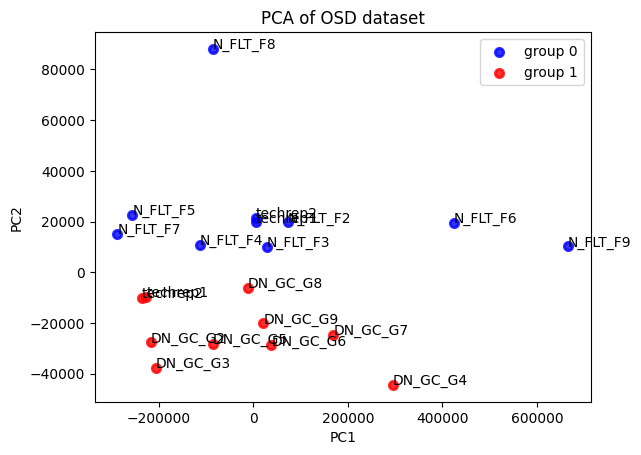

In [ ]:
# call run_pca on expr_df_factors
plt = run_pca(expr_df_factors, meta_df_factors, samples_0, samples_1, list(factors['factor']))
plt.savefig(DGEA_DIR + '/pca.png')
plt.show()

If you encounter any outliers,  you may wish to remove them from your expr_df_factors and meta_df_factors dataframes before running DGEA.

# Perform differential gene expression analysis

In [ ]:
# create dataframe with 'sample' column removed for DESeq2
import numpy as np
counts = expr_df_factors.drop(columns=['sample']).reset_index(drop=True)
# check for non-numeric
counts.applymap(np.isreal)
# convert all cells to integers
counts = counts.astype(int)
counts.shape

(20, 6891)

You can read more about the pyDeseq2 package in [this document](https://pydeseq2.readthedocs.io/en/stable/api/index.html#).

In [ ]:
# run the DESEq2 experiment contrasting condition "0" (ground control) to condition "1" (space flight)
# store the results in a dataframe called "res"
dds = DeseqDataSet(counts=counts, metadata=factors, design_factors="factor")
dds.deseq2()
stats_results = DeseqStats(dds, contrast = ('factor', '0', '1'))
stats_results.summary()
res = stats_results.results_df

Using None as control genes, passed at DeseqDataSet initialization


/tmp/ipython-input-1809659324.py:3: DeprecationWarning: design_factors is deprecated and will soon be removed.Please consider providing a formulaic formula using the design argumentinstead.
  dds = DeseqDataSet(counts=counts, metadata=factors, design_factors="factor")
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 9.40 seconds.

Fitting dispersion trend curve...
... done in 0.35 seconds.

Fitting MAP dispersions...
... done in 11.25 seconds.

Fitting LFCs...
... done in 6.79 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 33 outlier genes.

Fitting dispersions...
... done in 0.14 seconds.

Fitting MAP dispersions...
... done in 0.15 seconds.

Fitting LFCs...
... done in 0.12 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value: factor 0 vs 1
                     baseMean  log2FoldChange     lfcSE      stat    pvalue  \
ENSMUSG00000000031   1.137881       -0.449745  0.723892 -0.621288  0.534410   
ENSMUSG00000000037   5.831842       -0.062853  0.391665 -0.160475  0.872507   
ENSMUSG00000000120  12.577331        0.257565  0.296213  0.869528  0.384558   
ENSMUSG00000000142  41.385844        0.916447  0.274932  3.333362  0.000858   
ENSMUSG00000000197  13.657887        0.979916  0.297872  3.289728  0.001003   
...                       ...             ...       ...       ...       ...   
ENSMUSG00002076860   2.610404       -0.539096  0.502520 -1.072785  0.283368   
ENSMUSG00002076874   6.073786        0.283396  0.376716  0.752280  0.451883   
ENSMUSG00002076902   4.608025       -0.314740  0.433271 -0.726426  0.467577   
ENSMUSG00002076903   2.019218        0.297345  0.560285  0.530702  0.595625   
ENSMUSG00002076983   6.461291        0.081474  0.385303  0.211453  0.832534   


... done in 2.48 seconds.



In [ ]:
# extract results of the DESeq2 experiment where  padj < 0.05, and log2fc > LOG2FC_THRESH
sigs = res[(res.padj < ALPHA_LEVEL) & (abs(res.log2FoldChange) > LOG2FC_THRESH)]
print(sigs.shape)
# convert gene id to gene symbol
sigs['gene_symbol'] = get_symbol_from_id(list(sigs.index))
print('first 5 sigs: ', sigs.head())
sigs.to_csv(DGEA_DIR + '/sigs.csv', sep=',')

INFO:biothings.client:querying 1-288 ...


(288, 6)


INFO:biothings.client:Finished.
INFO:biothings.client:Pass "returnall=True" to return complete lists of duplicate or missing query terms.


first 5 sigs:                         baseMean  log2FoldChange     lfcSE       stat  \
ENSMUSG00000002265  2241.807081        2.061031  0.194348  10.604870   
ENSMUSG00000002266   241.917054        2.425842  0.273635   8.865255   
ENSMUSG00000005413  2472.018219       -1.706609  0.512361  -3.330870   
ENSMUSG00000005800    10.020104       -3.251711  0.965904  -3.366496   
ENSMUSG00000009092    27.368063       -2.534934  0.468635  -5.409184   

                          pvalue          padj gene_symbol  
ENSMUSG00000002265  2.828572e-26  8.987788e-23        Peg3  
ENSMUSG00000002266  7.632913e-19  6.929594e-16        Zim1  
ENSMUSG00000005413  8.657491e-04  9.842282e-03       Hmox1  
ENSMUSG00000005800  7.612958e-04  8.893447e-03        Mmp8  
ENSMUSG00000009092  6.331254e-08  4.470569e-06       Derl3  


/tmp/ipython-input-4204195135.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sigs['gene_symbol'] = get_symbol_from_id(list(sigs.index))


In [ ]:
# write differentially expressed gene list to file
deg_genes = list(sigs.index)
deg_gene_symbols = get_symbol_from_id(deg_genes)
with open(f"{DGEA_DIR}/deg_genes.txt", "w") as f:
  for gene in deg_gene_symbols:
    f.write(gene + "\n")
f.close()

# check gene file
!head {DGEA_DIR}/deg_genes.txt

INFO:biothings.client:querying 1-288 ...
INFO:biothings.client:Finished.
INFO:biothings.client:Pass "returnall=True" to return complete lists of duplicate or missing query terms.


Peg3
Zim1
Hmox1
Mmp8
Derl3
4930579F01Rik
Bcas1
C4a
Sec14l4
Nav3


In [ ]:
# write list of background genes to file
bg_genes = get_symbol_from_id(list(expr_df.drop(columns=['sample'])))

with open(f"{DGEA_DIR}/background_genes.txt", "w") as f:
  for gene in bg_genes:
    f.write(gene + "\n")
f.close()

# check gene file
!head {DGEA_DIR}/background_genes.txt

INFO:biothings.client:querying 1-1000 ...
INFO:biothings.client:querying 1001-2000 ...
INFO:biothings.client:querying 2001-3000 ...
INFO:biothings.client:querying 3001-4000 ...
INFO:biothings.client:querying 4001-5000 ...
INFO:biothings.client:querying 5001-6000 ...
INFO:biothings.client:querying 6001-6891 ...
INFO:biothings.client:Finished.
INFO:biothings.client:Pass "returnall=True" to return complete lists of duplicate or missing query terms.


H19
Scml2
Ngfr
Axin2
Nalcn
Slfn4
Drp2
Clec10a
Rem1
Rnf17


# Create volcano plot

You can learn more about how this volcano plot was generated reading [this article](https://bioinformatics.ccr.cancer.gov/docs/pies-2023/pies_lesson4/).

INFO:biothings.client:querying 1-10 ...
INFO:biothings.client:Finished.


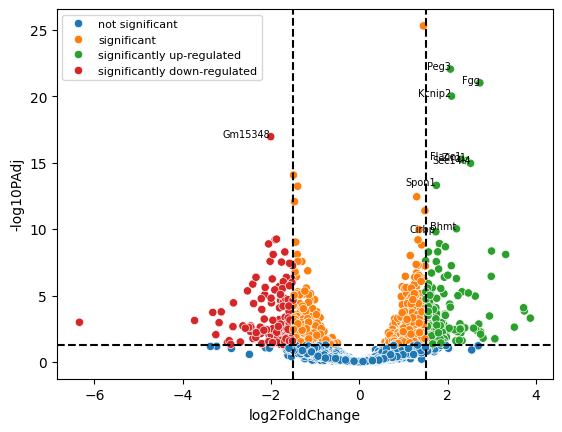

In [ ]:
# import Python modules for plotting volcano
import pandas
import numpy
import matplotlib.pyplot as plt
import seaborn

# create column for -log10PAdj from existing padj
res['-log10PAdj'] = -numpy.log10(res['padj'])

# create column for significance from existing log2FoldChange and -log10PAdj
significance = []
for i in range(len(res)):
    if res.iloc[i]['log2FoldChange'] > LOG2FC_THRESH and res.iloc[i]['-log10PAdj'] > -numpy.log10(ALPHA_LEVEL):
        significance.append('significantly up-regulated')
    elif res.iloc[i]['log2FoldChange'] < -LOG2FC_THRESH and res.iloc[i]['-log10PAdj'] > -numpy.log10(ALPHA_LEVEL):
        significance.append('significantly down-regulated')
    elif res.iloc[i]['-log10PAdj'] > -numpy.log10(ALPHA_LEVEL) and res.iloc[i]['padj'] < ALPHA_LEVEL:
        significance.append('significant')
    else:
        significance.append('not significant')

res['significance'] = significance
# plot the degs
plot1 = seaborn.scatterplot(res, x = "log2FoldChange", y = "-log10PAdj", hue = "significance")

# sort to get top 10 significant genes
top10 = sigs[sigs['padj'] < ALPHA_LEVEL].sort_values(by=['padj', 'log2FoldChange'], ascending=[True, False]).head(10)

# add gene_symbol to top10
gene_symbol_list = get_symbol_from_id(list(top10.index))
top10['gene_symbol'] = gene_symbol_list

# add -log10PAdj to top10
top10['-log10PAdj'] = -numpy.log10(top10['padj'])

# annotate top 10 significant genes
for i in range(top10.shape[0]):
    gene = top10.iloc[i]
    plt.text(gene['log2FoldChange'], gene['-log10PAdj'], gene['gene_symbol'], fontsize=7, ha='right')

# draw a line at y=5 for significance
plt.axhline(y = -numpy.log10(ALPHA_LEVEL), color='black', linestyle='--')

# draw 2 lines at fold change threshold
plt.axvline(x = LOG2FC_THRESH, color = 'black', linestyle='--')
plt.axvline(x = -LOG2FC_THRESH, color='black', linestyle='--')

# set font size for legend
plt.legend(fontsize=8)

plt.savefig(DGEA_DIR + '/volcano.png')

plt.show()




The horizontal line (y=-numpy.log10(ALPHA_LEVEL) represents the negative log of the p-value threshold for the adjusted p-values (-log10PAdj). The value 0.05 is the standard alpha level of significance for most scientific research. We defined ALPHA_LEVEL at the top of this notebook. You can read more about the alpha level of significance [here](https://en.wikipedia.org/wiki/Statistical_significance).

The two vertical lines (x=-LOG2FC_THRESH and x=+LOG2FC_THRESH) represent the number of times up- and down-regulated the gene expression value is between the 2 conditions of the 2 groups, respectively. We defined the LOG2FC_THRESH value at the top of this notebook. You can read more about the log2 fold-change threshold for DGEA [here](https://www.biostars.org/p/9505003/).

The list of differentially expressed genes include those which are significantly down-regulated (in green) and significantly up-regulated (in red). Note that only the top 10 most significant genes are annotated.

# Check your work before moving on

In [ ]:
# make sure your google drive disk space utilization is still under 15G
# should be about 2.4GB
!du -sh /content/mnt/MyDrive/NASA/GL4HS

2.5G	/content/mnt/MyDrive/NASA/GL4HS


In [ ]:
# time the notebook
import datetime
end_time = datetime.datetime.now()
print('notebook end time: ', end_time.strftime('%Y-%m-%d %H:%M:%S'))

print('notebook runtime: ', end_time - start_time)
#

notebook end time:  2025-08-15 03:27:23
notebook runtime:  0:02:43.097465
